# Generating benchmark data with 2 covariates

## p=30

In [12]:
import pandas as pd
import toytree as tt
import numpy as np
import anndata as ad
import os
import toyplot as tp
import toyplot.svg

import tree_aggregation.tree_data_generation as tgen
import sccoda.util.data_visualization as viz

In [13]:
# tree depth
d = 5

effect_sizes = [0.3, 0.5, 0.7, 0.9]
# number of effects
num_effects = 3
# baseline parameter scale
a_abs = 2

# sampling depth
N = 10000
# dispersion
theta = 499
# samples per group
num_samples = [20]
reps = 20


# counter through all datasets
id = 0
dataset_path = os.path.abspath("../../benchmarking_2/benchmark_2_cov/data/datasets2")
print(dataset_path)

/Users/johannes.ostner/Documents/PhD/tree_aggregation/benchmarking_2/benchmark_2_cov/data/datasets2


In [14]:
# Want everything to be reproducible - set a seed at every block
np.random.seed(96)
p = 30
id = 0

newick = tgen.generate_tree_levels(p, d)

tree = tt.tree(newick)
tree.draw(tip_labels_align=True, node_sizes=10, node_labels='idx')

(<toyplot.canvas.Canvas at 0x7fe1a8324af0>,
 <toytree.Render.ToytreeMark at 0x7fe1a84e6b50>)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="260.0px" height="540.0px" viewBox="0 0 260.0 540.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="ta8104180b5834623ad0b5ae8ea9c349f"> 30 31 32 33 34 35 36 37 38 39 40 41 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29

In [15]:
np.random.seed(76)
effect_nodes, effect_leaves = tgen.get_effect_nodes(
    newick,
    num_effects=num_effects,
    num_leaves=p
)

print(f"nodes: {effect_nodes}")
print(f"leaves: {effect_leaves}")

tlc = ["red" if int(i) in effect_leaves else "blue" if int(i)==p-1 else "black" for i in tree.get_node_values("idx", 1, 1)[-p:]]
tlc.reverse()
ref_nodes = [p.idx for p in tree.idx_dict[p-1].get_ancestors()][:-1]
ref_nodes.append(p-1)

canvas = tp.Canvas(width=800, height=1600)
ax0 = canvas.cartesian(bounds=(0, 700, 0, 1600), padding=0)
tree.draw(
    # tip_labels=False,
    node_sizes=[20 for i in tree.get_node_values("name", 1, 1)],
    node_labels=[x for x in tree.get_node_values("idx", 1, 1)],
    node_colors=["lightcoral" if i in effect_nodes else "lightblue" if i in ref_nodes else "lightgrey" for i in tree.get_node_values("idx", 1, 1)],
    node_labels_style={"font-size": 10},
    width=700,
    height=1600,
    node_style={"stroke": "black"},
    axes=ax0,
    tip_labels="name",
    tip_labels_colors=tlc,
)
# tp.svg.render(canvas, "../../paper_stuff/benchmark_tree_30.svg")

effect_nodes: [33, 7, 0]
effect_leaves: [0, 7, 13, 14, 15, 16]
nodes: [33, 7, 0]
leaves: [0, 7, 13, 14, 15, 16]


(None,
 <toytree.Render.ToytreeMark at 0x7fe1a83bf880>)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="800.0px" height="1600.0px" viewBox="0 0 800.0 1600.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t3d7e3093a8ba472bae4eaec599aad8ee"> 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 -4 -3 -2 -1 0 0 10 20 30

In [19]:
x1_nodes = [39]
x1_leaves = np.arange(13, 24, 1)
beta_1 = np.zeros(p)
beta_1[x1_leaves] = 1
print(x1_leaves)

np.random.seed(1234)
for e in effect_sizes:
    for n in num_samples:
        for r in range(reps):

            mu_0, mu_1 = tgen.generate_mu(
                a_abs=a_abs,
                num_leaves=p,
                effect_nodes=effect_nodes,
                effect_leaves=effect_leaves,
                effect_size=e,
                newick=newick
            )

            X = pd.DataFrame({"x_0": np.repeat([0,1], 2*n), "x_1": np.random.uniform(-0.1, 0.1,4*n) + 3})
            Y = np.zeros((n*4, p))
            for i in range(n):
                Y[i, :] = tgen.generate_one_sample(N, mu_0, theta)
                Y[i+n, :] = tgen.generate_one_sample(N, mu_0 + beta_1*X.loc[i+n, "x_1"], theta)
                Y[i+2*n, :] = tgen.generate_one_sample(N, mu_1, theta)
                Y[i+3*n, :] = tgen.generate_one_sample(N, mu_1 + beta_1*X.loc[i+3*n, "x_1"], theta)

            X = X.astype(np.float64)
            Y = Y.astype(np.float64)

            test_data = ad.AnnData(
                X=Y,
                obs=X,
                uns={
                    "tree_newick": newick,
                    "effect_nodes": effect_nodes,
                    "effect_leaves": effect_leaves,
                    "effect_size": e,
                    "num_samples": n,
                }
            )

            test_data.write_h5ad(dataset_path + f"/data_{id}")
            id += 1



[13 14 15 16 17 18 19 20 21 22 23]


/Users/johannes.ostner/opt/anaconda3/envs/scCODA_3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [20]:
test_data.obs

,x_0,x_1
0,0.0,2.926080
1,0.0,2.969721
2,0.0,3.021611
3,0.0,3.051299
4,0.0,3.082841
...,...,...
75,1.0,3.064642
76,1.0,3.041122
77,1.0,3.069285
78,1.0,2.992592


<AxesSubplot:xlabel='Cell type', ylabel='Proportion'>

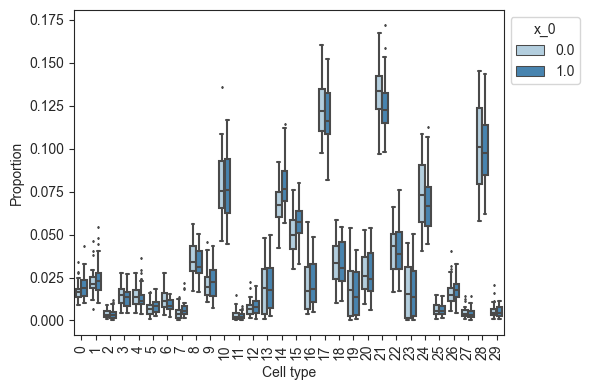

In [22]:
dat = ad.read_h5ad(dataset_path + "/data_10")
viz.boxplots(dat, "x_0")